In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np

from scipy.constants import speed_of_light
from scipy.fft import fft, fftfreq
from scipy.fftpack import ifft, idct, dct
import scipy.fftpack as spfft
import cvxpy as cvx

# LaTeX type definitions
rc('font', **{'family': 'sans serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)


In [2]:
# Run this cell if you need to install TeX for plots 

!sudo apt-get install texlive-latex-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
!unzip type1cm.zip -d /tmp/type1cm 
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm 
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
!sudo texhash

!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [3]:
def channel_model(bs_gain, bs_pos,
                  ue_gain, ue_pos,
                  ris_size_el, ris_num_els_hor, ris_num_els_ver, ris_configs):
    """Get Downlink (DL) and Uplink (UL) channel gain.

    Returns
    -------
    channel_gains_dl : ndarray of shape (num_configs, num_ues)
        Downlink channel gain between the BS and each UE for each RIS configuration.

    channel_gains_ul : ndarray of shape (num_configs, num_ues)
        Uplink channel gain between the BS and each UE for each RIS configuration.

    """

    # Extract distances and angles
    bs_distance = np.linalg.norm(bs_pos)
    bs_angle = np.arctan2(bs_pos[0], bs_pos[1])

    ue_distances = np.linalg.norm(ue_pos, axis=0)
    ue_angles = np.arctan2(ue_pos[0, :], ue_pos[1, :])

    # Compute constant term
    num = bs_gain * ue_gain * (ris_size_el * ris_size_el)**2
    den = (4 * np.pi * bs_distance * ue_distances)**2

    const = num/den
    
    # Compute DL pathloss component of shape (num_ues, )
    pathloss_dl = const * np.cos(bs_angle)**2

    # Compute UL pathloss component of shape (num_ues, )
    pathloss_ul = const * np.cos(ue_angles)**2

    # Compute constant phase component of shape (num_ues, )
    distances_sum = (bs_distance + ue_distances)
    disagreement = (np.sin(bs_angle) - np.sin(ue_angles)) * ((ris_num_els_hor + 1) / 2) * ris_size_el

    phi = - wavenumber * (distances_sum - disagreement)
    
    # Compute array factor of shape (num_configs, num_ues)
    enumeration_num_els_x = np.arange(1, ris_num_els_hor + 1)
    sine_differences = (np.sin(ue_angles[np.newaxis, :, np.newaxis]) - np.sin(ris_configs[:, np.newaxis, np.newaxis]))

    argument = wavenumber * sine_differences * enumeration_num_els_x[np.newaxis, np.newaxis, :] * ris_size_el

    array_factor_dl = ris_num_els_ver * np.sum(np.exp(+1j * argument), axis=-1)
    array_factor_ul = array_factor_dl.conj()

    # Compute channel gains of shape (num_configs, num_ues)
    channel_gains_dl = np.sqrt(pathloss_dl[np.newaxis, :]) * np.exp(+1j * phi[np.newaxis, :]) * array_factor_dl
    channel_gains_ul = np.sqrt(pathloss_ul[np.newaxis, :]) * np.exp(-1j * phi[np.newaxis, :]) * array_factor_ul

    return channel_gains_dl, channel_gains_ul
    

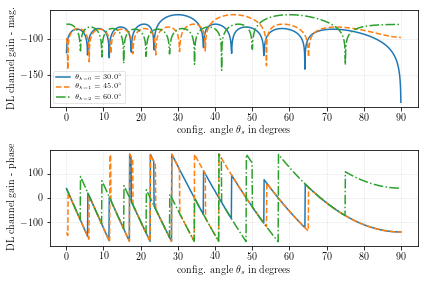

In [4]:
########################################
# Parameters
########################################

#-----
# Eletromagnetics
#-----

# Signal
carrier_frequency = 3e9
wavelength = speed_of_light / carrier_frequency
wavenumber = 2 * np.pi / wavelength

# Distances
#maximum_distance = 100

# Noise
noise_power = 10 ** (-94.0 / 10)  # mW

#-----
# RIS
#-----

# Number of configurations
ris_num_configs = 1001

# Number of elements
ris_num_els_ver = ris_num_els_hor = 10  # vertical/horizontal

# Size of each element
ris_size_el = wavelength

# RIS size along one of the dimensions
ris_size = ris_num_els_ver * ris_size_el

# RIS configurations
ris_angular_resolution = ((np.pi / 2) - 0) / ris_num_configs
ris_configs = np.arange(ris_angular_resolution / 2, np.pi / 2, ris_angular_resolution)

# Minimum distant to RIS
minimum_distance = (2/wavelength) * ris_size**2

#-----
# BS
#-----

# BS antenna gain
bs_gain = 10**(5/10)

# Position
bs_angle = np.deg2rad([-45.0])
bs_pos = minimum_distance * np.array([np.sin(bs_angle), np.cos(bs_angle)])

#-----
# UE
#-----

# UE antenna gain
ue_gain = 10**(5/10)

# Define specific positions for the UEs
ue_angles_deg = np.array([30.0, 45.0, 60.0])
#ue_angles_deg = np.array([45.0])
ue_angles = np.deg2rad(ue_angles_deg)

# Prepare to save UE positions
ue_pos = np.zeros((3, ue_angles_deg.size))

# Compute UE positions
ue_pos[0, :] = np.sin(ue_angles)
ue_pos[1, :] = np.cos(ue_angles)

ue_pos *= minimum_distance

# Get channel gains for the UEs
channel_gains_dl, channel_gains_ul = channel_model(bs_gain, bs_pos, ue_gain, ue_pos, ris_size_el, ris_num_els_hor, ris_num_els_ver, ris_configs)

# Plot channel gain vs number of configurations 
fig, axes = plt.subplots(2, 1)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), 20*np.log10(np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
    axes[1].plot(np.rad2deg(ris_configs), np.rad2deg(np.angle(channel_gains_dl[:, ue])), markers[ue])

axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('DL channel gain - mag.')
axes[1].set_ylabel('DL channel gain - phase')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

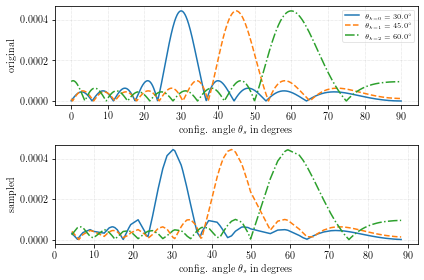

In [5]:
# Focus on the magnitude of the signal 
abs_channel_gains_dl = np.abs(channel_gains_dl)

# Define number of sampling points
num_samples = 101 #int(0.01 * ris_num_configs)

# Random sampling indexes
random_indexes = np.random.choice(ris_num_configs, num_samples, replace=False)
random_indexes.sort()

# Performing sampling
sampled_channel_gains_dl = abs_channel_gains_dl[random_indexes, :]

# Plot samples signal against original one
fig, axes = plt.subplots(2, 1)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), (np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
    axes[1].plot(np.rad2deg(ris_configs)[random_indexes], (np.abs(sampled_channel_gains_dl[:, ue])), markers[ue])

axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('original')
axes[1].set_ylabel('sampled')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

In [6]:
# # Evaluate the Fourier transform of the signal 
# sampled_channel_gains_dl_freq = fft(sampled_channel_gains_dl)
# ris_configs_frequency = fftfreq(num_samples, num_samples/ris_num_configs)[:num_samples//2]

# # Plot samples signal against original one
# fig, ax = plt.subplots(1, 1)

# # Create a marker vector
# markers = ['-', '--', '-.', ':']

# # Go through all UEs
# for ue in range(ue_angles_deg.size):

#     label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'
#     ax.plot(ris_configs_frequency, 2.0/num_samples * np.abs(sampled_channel_gains_dl_freq[0:num_samples//2, ue]), markers[ue], label=label)

# plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

# ax.set_xlabel(r'ris configs frequency')
# ax.set_ylabel('fft')

# plt.tight_layout()

# plt.show()

# print(sampled_channel_gains_dl.shape)
# print(sampled_channel_gains_dl_freq.shape)

In [7]:
# Model A as DCT - discrete cosine transform 
A = spfft.idct(np.identity(ris_num_configs), norm='ortho', axis=0)
#A = dct(np.eye(ris_num_configs))
A = A[random_indexes]

# Prepare to save recovered channel gains
recovered_channel_gains_dl = np.zeros((ris_num_configs, ue_angles_deg.size))

# Go through all UEs
for ue in range(ue_angles_deg.size):

  # Optimization variable
  vx = cvx.Variable((ris_num_configs, 1))

  # Objective
  objective = cvx.Minimize(cvx.norm(vx, 1))

  # Contraints
  constraints = [A * vx == (sampled_channel_gains_dl[:, ue])[:, np.newaxis]]
  
  # Perform L1 optimization 
  prob = cvx.Problem(objective, constraints)
  result = prob.solve(verbose=True)
  # Store solution
  recovered_channel_gains_dl[:, ue] = np.squeeze(np.array(vx.value))

  del vx, objective, constraints, prob

# Reconstruct original signal
reconstructed_channel_gains_dl = idct(recovered_channel_gains_dl, norm='ortho', axis=0)

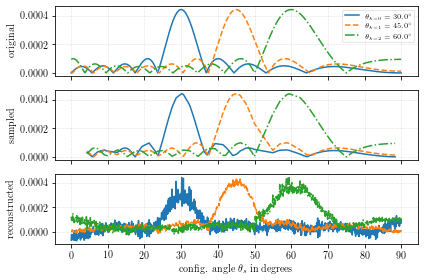

In [8]:
# Plot samples signal against original one
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

# Create a marker vector
markers = ['-', '--', '-.', ':']

# Go through all UEs
for ue in range(ue_angles_deg.size):

    label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

    axes[0].plot(np.rad2deg(ris_configs), np.abs(channel_gains_dl[:, ue]), markers[ue], label=label)
    
    axes[1].plot(np.rad2deg(ris_configs)[random_indexes], sampled_channel_gains_dl[:, ue], markers[ue])

    axes[2].plot(np.rad2deg(ris_configs), reconstructed_channel_gains_dl[:, ue], markers[ue])

#axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
#axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')
axes[2].set_xlabel(r'config. angle $\theta_s$ in degrees')

axes[0].set_ylabel('original')
axes[1].set_ylabel('sampled')
axes[2].set_ylabel('reconstructed')

axes[0].set_xticks(np.arange(0, 100, 10))
axes[1].set_xticks(np.arange(0, 100, 10))
axes[2].set_xticks(np.arange(0, 100, 10))

axes[0].legend(fontsize='x-small', framealpha=0.5)

axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
axes[2].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

In [ ]:
# Model A as DCT - discrete cosine transform 
D = idct(np.identity(ris_num_configs), norm='ortho', axis=0)

# Methods 
methods = ['random', 'uniform']

# Range of number of samples
num_samples_range = np.concatenate(
    (
    np.arange(5, 120, 5),
    #np.arange(100, ris_num_configs, 100)
    )
)

#np.array([100, 200, 300, 400, 500])#np.arange(10, 1001)

# Number of realizations
num_realizations = 20

# Create a vector to store MSE
nmse = np.empty((len(methods), ue_angles_deg.size, num_samples_range.size, num_realizations))

# Go through all methods
for mm, method in enumerate(methods):

  # Go through all UEs
  for ue in range(ue_angles_deg.size):

    # Go through all samples
    for nn, num_samples in enumerate(num_samples_range):

      for rr in range(num_realizations):

        if method == 'random':

          # Random sampling indexes
          indexes = np.random.choice(ris_num_configs, num_samples, replace=False)
          indexes.sort()

        elif method == 'uniform':

          # Uniformly sampling indexes
          indexes = np.arange(0, ris_num_configs, ris_num_configs//num_samples)

        # Performing sampling
        sampled_channel_gains_dl = abs_channel_gains_dl[indexes]

        # Extract columns from A
        A_ = D[indexes]

        # Perform L1 optimization
        vx = cvx.Variable((ris_num_configs, 1))

        objective = cvx.Minimize(cvx.norm(vx, 1))
        constraints = [A_ * vx == sampled_channel_gains_dl[:, ue][:, np.newaxis]]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve(verbose=True)

        # Reconstruct original signal
        recovered_channel_gains_dl = np.squeeze(np.array(vx.value))
        reconstructed_channel_gains_dl = idct(recovered_channel_gains_dl, norm='ortho', axis=0)

        # Compute NMSE
        if method == 'random':   
          nmse[mm, ue, nn, rr] = np.linalg.norm(abs_channel_gains_dl[:, ue] - reconstructed_channel_gains_dl)**2/np.linalg.norm(abs_channel_gains_dl[:, ue]**2)

        else: 
          nmse[mm, ue, nn, :] = np.linalg.norm(abs_channel_gains_dl[:, ue] - reconstructed_channel_gains_dl)**2/np.linalg.norm(abs_channel_gains_dl[:, ue]**2)
          break


In [ ]:
# Print the best NMSE points
best_indexes = np.argmin(nmse, axis=1)

print(methods[0] + ' = ' + str(num_samples_range[best_indexes[0]]))
print(methods[1] + ' = ' + str(num_samples_range[best_indexes[1]]))


random = [[10 10  5 15  5 15 10  5  5 10  5 10 15  5  5  5 10  5  5  5]
 [ 5  5 10  5 15 10 10  5 15 10 15  5  5 10 10  5  5  5 10 15]
 [10 10 10 10 15 10  5  5 10 10 10  5 15 15 10  5  5 10  5  5]
 [10 10 10 10  5 10  5 10 15  5 10 10  5  5  5  5 10  5 10 15]
 [15 10  5  5  5 15 10 10 15 10 10  5 15 10 15 15  5 15 15 10]
 [10 10  5 10 10 15 15 15 10  5  5 10 15 10 15 10 15  5 10 15]
 [15 15 15 10 15 15 10 10 15 15 10  5  5  5 15 15 15 10 15 15]
 [10  5  5 10 10 10 10 15 10 15 15 10 15 15 15 10 10 10 10 10]
 [15 15 10 10 15 15 15  5 10  5  5 10 15 15 10  5 10 10 10 15]
 [ 5 10 10 15 10 10 10 15 10 15 10 10 15 15 10 10 15 15 10 15]
 [10 15 10 10 10 15 10 10 10 10 10 10 15 15 10 15 15 10 10 10]
 [ 5 15 15 10 10 15 10 10 10 10 10 15 15 15  5 15 15  5 10 15]
 [15 10 10 15 10 15 10 15  5  5 10 10 10 10 10 15 15 10 15 10]
 [10 15 10 10 10 10 10 15 10 10 10 10 10 10 10 15 10 10 10 15]
 [10 15 10  5 15 10 10 10 15 15  5 15 15 15 10 10 10 15 10 10]
 [15 10 10 10 10 10 15 10 15 15 15 10 10 15 10

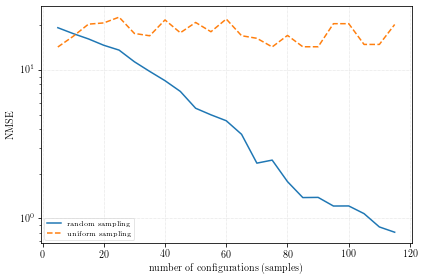

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(num_samples_range, np.mean(nmse[0, :, :, :], axis=(-1, 0)), label='random sampling', linestyle='-')
ax.plot(num_samples_range, np.mean(nmse[1, :, :, :], axis=(-1, 0)), label='uniform sampling', linestyle='--')

ax.set_yscale('log')

ax.set_xlabel('number of configurations (samples)')
ax.set_ylabel('NMSE')

ax.legend(fontsize='x-small', framealpha=0.5)
ax.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()

In [ ]:
# from sklearn import linear_model

# D = dct(np.eye(ris_num_configs)) # Here, we model using the DCT
# A = D[random_indexes, :]

# # Solve the problem using the LASSO algorithm 
# lasso = linear_model.Lasso(alpha=0.001)
# lasso.fit(A, sampled_channel_gains_dl.reshape((num_samples,)))
# print(sampled_channel_gains_dl.shape)

# # Reconstruct original signal
# reconstructed_channel_gains_dl_lasso = idct(lasso.coef_.reshape((ris_num_configs, 1)), norm='ortho', axis=0)

# # Plot samples signal against original one
# fig, axes = plt.subplots(3, 1)

# # Create a marker vector
# markers = ['-', '--', '-.', ':']

# # Go through all UEs
# for ue in range(ue_angles_deg.size):

#     label = r'$\theta_{k=' + str(ue) + '} =' + str(np.round(ue_angles_deg[ue], 2)) + '^{\circ}$'

#     axes[0].plot(np.rad2deg(ris_configs), (np.abs(channel_gains_dl[:, ue])), markers[ue], label=label)
#     axes[1].plot(np.rad2deg(ris_configs)[random_indexes], (np.abs(sampled_channel_gains_dl[:, ue])), markers[ue])
#     axes[2].plot(np.rad2deg(ris_configs), (np.abs(reconstructed_channel_gains_dl_lasso)), markers[ue])

# axes[0].set_xlabel(r'config. angle $\theta_s$ in degrees')
# axes[1].set_xlabel(r'config. angle $\theta_s$ in degrees')
# axes[2].set_xlabel(r'config. angle $\theta_s$ in degrees')

# axes[0].set_ylabel('original')
# axes[1].set_ylabel('sampled')
# axes[2].set_ylabel('reconstructed')

# axes[0].set_xticks(np.arange(0, 100, 10))
# axes[1].set_xticks(np.arange(0, 100, 10))
# axes[2].set_xticks(np.arange(0, 100, 10))

# axes[0].legend(fontsize='x-small', framealpha=0.5)

# axes[0].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[1].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[2].grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

# plt.tight_layout()